# Hough Transform

In this exercise, we will implement a Hough transform in order to detect parametric curves, such as lines or circles.
In the following, we shortly review the motivation for this technique.

Consider the point $p=(\mathtt{x},\mathtt{y})$ and the equation for a line $y = mx+c$. What are the lines that could pass through $p$?
The answer is simple: all the lines for which $m$ and $c$ satisfy $\mathtt{y} = m\mathtt{x}+c$.
Regarding $(\mathtt{x},\mathtt{y})$ as fixed, the last equation is that of a line in $(m,c)$-space.
Repeating this reasoning, a second point $p'=(\mathtt{x}',\mathtt{y}')$ will also have an associated line in parameter space, and the two lines will intersect at the point $(\tilde{m},\tilde{c})$, which corresponds to the line connecting $p$ and $p'$.

In order to find lines in the input image, we can thus pursue the following approach.
We start with an empty accumulator array quantizing the parameter space for $m$ and $c$.
For each edge pixel in the input image, we then draw a line in the accumulator array and increment the corresponding cells.
Edge pixels on the same line in the input image will produce intersecting lines in $(m,c)$-space and will thus reinforce the intersection point.
Maxima in this array thus correspond to lines in the input image that many edge pixels agree on.

In practice, the parametrization in terms of $m$ and $c$ is problematic, since the slope $m$ may become infinite.
Instead, we use the following parametrization in polar coordinates:
\begin{equation}
	\mathtt{x}\cos\theta + \mathtt{y}\sin\theta = \rho \label{eq:hough_line}
\end{equation}
This produces a sinusoidal curve in $(\rho,\theta)$-space, but otherwise the procedure is unchanged.

The following sub-questions will guide you through the steps of building a Hough transform.

In [5]:
%%html
<!-- Run this cell to add heading letters per subtask (like a, b, c) -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section, lower-alpha) ") ";}
</style>

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

## Hough Voting
Build up an accumulator array ``acc`` for the parameter space $(\rho, \theta)$. $\theta$ ranges from $-\pi/2$ to $\pi/2$, and $\rho$ ranges from $-D$ to $D$, where $D$ denotes the length of the image diagonal.
Use ``n_bins_rho`` and ``n_bins_theta`` as the number of bins in each direction.
Initially, the array should be filled with zeros.

For each edge pixel in the input image, create the corresponding curve in $(\rho, \theta)$ space by evaluating above line equation for all values of $\theta$ and incrementing the corresponding cells of the accumulator array.

In [3]:
def hough_transform(edge_image, n_bins_rho, n_bins_theta):
    # Vote accumulator
    votes = np.zeros((n_bins_rho, n_bins_theta), dtype=np.int)  
    
    # Create bins
    diag = np.linalg.norm(edge_image.shape)  # Length of image diagonal
    theta_bins = np.linspace(-np.pi / 2, np.pi / 2, n_bins_theta)
    rho_bins = np.linspace(-diag, diag, n_bins_rho)
    
    # YOUR CODE HERE
    for x in range(edge_image.shape[1]):
        for y in range(edge_image.shape[0]):
            for i in range(len(theta_bins)-2):
                theta=theta_bins[i]
                d=int(x*np.cos(theta)+y*np.sin(theta))
                d_index=int((d+diag)/n_bins_rho)
                votes[i][d_index]+=1
    #raise NotImplementedError()
    return votes, rho_bins, theta_bins

Now we can test the implementation on an example image and visualize the resulting Hough space by displaying it as a 2D image.

<IPython.core.display.Javascript object>


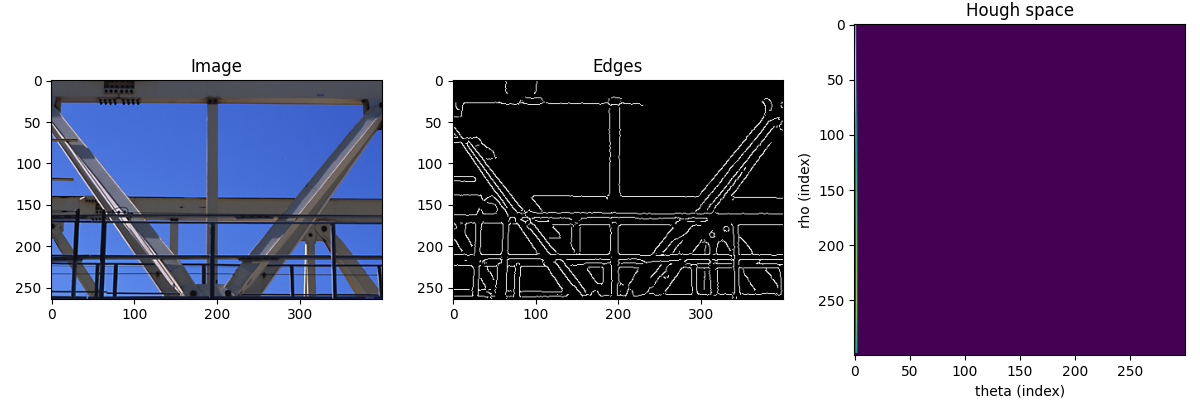

In [6]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY)

# Get edges using Canny
blurred = cv2.GaussianBlur(gray_im, None, sigmaX=2.5)
edges = cv2.Canny(blurred, threshold1=30, threshold2=50)

hough_space, rho_bins, theta_bins = hough_transform(edges, n_bins_rho=300, n_bins_theta=300)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(color_im)
axes[0].set_title('Image')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Edges')
axes[2].imshow(hough_space)
axes[2].set_title('Hough space')
axes[2].set_xlabel('theta (index)')
axes[2].set_ylabel('rho (index)')
fig.tight_layout()

## Non-Maximum Suppression and Finding Peaks
Write a function ``nms2d`` which suppresses all points in the Hough space that are not local maxima.
This can be achieved by looking at the 8 direct neighbors of each pixel and keeping only pixels whose value is greater than all its neighbors.

This function is simpler than the non-maximum suppression from the Canny Edge Detector exercise, since it does not take into account local gradients.

Tip: think about what to do at the borders of the Hough array. What happens if we simply ignore the border areas? How should we treat it to be precise? (Remember that theta represents an angle that wraps around back to itself).

In [7]:
def nms2d(hough_array):
    hough_array_out = np.zeros_like(hough_array)
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1]
    offsets_y = [0, -1, -1, -1, 0, 1, 1, 1]    
    for x in range(hough_array.shape[1]):
        for y in range(hough_array.shape[0]):
            
            criterium=1
                
            for ox, oy in zip(offsets_x, offsets_y):
            # Note: `visited` is already False for points
            # below the low threshold.
                new_x=x+ox
                new_y=y+oy
            
               
                if new_x<hough_array.shape[1] and new_y<hough_array.shape[0]:
                    if hough_array[y][x]<hough_array[new_y][new_x]:
                        criterium=0
            if not criterium:
                hough_array_out[y][x]=hough_array[y][x]              
    return hough_array_out

Write a function ``find_hough_peaks`` that takes the result of ``hough_transform`` as an argument, finds the extrema in Hough space using ``nms2d`` and returns the index of all points $(\rho_i, \theta_i)$ for which the corresponding Hough value is greater than ``threshold``.

In [8]:
def find_hough_peaks(hough_space, threshold):
    # YOUR CODE HERE
    hough_out= (nms2d(hough_space)>threshold)
    temp_rho=[]
    temp_theta=[]
    for x in range(hough_out.shape[1]):
        for y in range(hough_out.shape[0]):
            if hough_out[y][x]:
                temp_rho.append(x)
                temp_theta.append(y)
                
    
    result_rho=np.asarray(temp_rho)
    result_theta=np.asarray(temp_theta)
    return result_rho,result_theta
    raise NotImplementedError()

What would happen if we swapped the order of the thresholding and the NMS operations?

YOUR ANSWER HERE

Now, let's plot the results of your implementation.

gantrycrane.png: found 719 lines in the image.


<IPython.core.display.Javascript object>


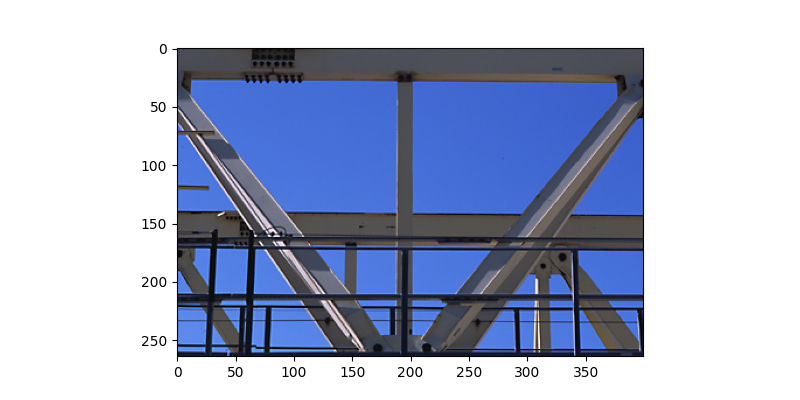

In [9]:
def plot_hough_lines(image, rho, theta):
    # compute start and ending point of the line x*cos(theta)+y*sin(theta)=rho
    x0, x1 = 0, image.shape[1] - 1
    y0 = rho / np.sin(theta)
    y1 = (rho - x1 * np.cos(theta)) / np.sin(theta)

    # Check out this page for more drawing function in OpenCV:
    # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    for yy0, yy1 in zip(y0, y1):
        cv2.line(image, (x0, int(yy0)), (x1, int(yy1)), color=(255, 0, 0), thickness=1)

    return image

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 200)
print(f'gantrycrane.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]

color_image = imageio.imread('gantrycrane.png')
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)

Is the result correct? Are there any undetected lines or wrong lines returned? If yes, why are those lines missing and why are there false positives? Can you think of ways to avoid those mistakes?

YOUR ANSWER HERE

circuit.png: found 618 lines in the image.


<IPython.core.display.Javascript object>


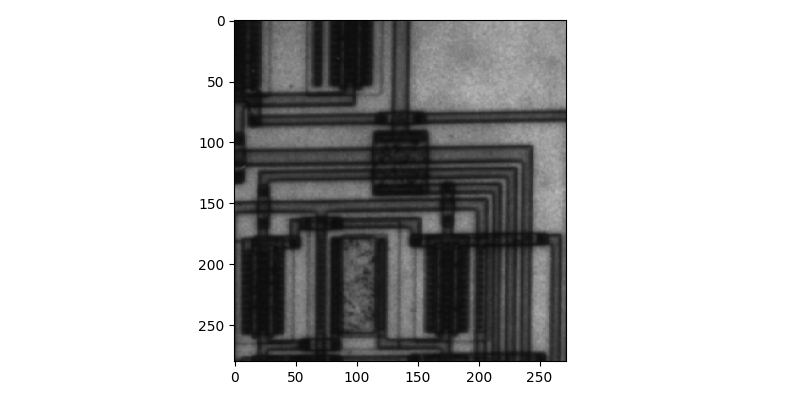

In [10]:
# Try another image
im = imageio.imread('circuit.png')

blurred = cv2.GaussianBlur(im, None, sigmaX=2)
edge = cv2.Canny(blurred, threshold1=30, threshold2=90)
hough_space, rho_bins, theta_bins = hough_transform(edge, n_bins_rho=300, n_bins_theta=300)

# Find maximum
rho_max_idx, theta_max_idx = find_hough_peaks(hough_space, 100)
print(f'circuit.png: found {len(rho_max_idx)} lines in the image.')
rho_max, theta_max = rho_bins[rho_max_idx], theta_bins[theta_max_idx]
color_image = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
image_with_lines = plot_hough_lines(color_image, rho_max, theta_max)

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(image_with_lines)
fig.tight_layout()

## [BONUS] Circle Hough Transform for Circles

The Hough transform is a general technique that can not only be applied to lines, but also to other parametric curves, such as circles.
In the following, we will show how the implementation can be extended to finding circles.

A circle can be parameterized by the following equation:
$$	
    (\mathtt{x}-a)^2 + (\mathtt{y}-b)^2 = r^2. \label{eq:hough_circle}
$$

Unfortunately, the computation and memory requirements for the Hough transform increase exponentially with the number of parameters.
While a 3D search space is still just feasible, we can dramatically reduce the amount of computation by integrating the gradient direction in the algorithm.

Without gradient information, all values $a, b$ lying on the cone given by above equation are incremented.
With the gradient information, we only need to increment points on an arc centered at $(a, b)$:
$$
\begin{eqnarray}
	a &=& x + r\cos\phi\\
	b &=& y + r\sin\phi,
\end{eqnarray}
$$
where $\phi$ is the gradient angle returned by the edge operator.

Create a function ``hough_circle`` which implements the Hough transform for circles.
Try your implementation for a practical application of counting coins in an image.
You can use the images ``coins1.png`` and ``coins2.png`` for testing.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## [BONUS] Line Hough Transform with Gradient Information 
The same trick (as in **Part c**) of using the image gradient can be used for lines.
Modify the code from **Part a** to only vote for one line per edge pixel, instead of all the lines running through this pixel.
Can you think of any disadvantages of this approach?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## [BONUS] Counting Coins

Can you build a demo application that takes a photo of several different Euro coins lying on a table as input and tells you how much money it is in total in Euros (i.e. the output is one number)?

How well does it work when the coins start to overlap or lie on top of each other?

Use the functions you wrote in the previous questions.
(Hint: you may need to include a reference shape in the picture in order to obtain the absolute scale, i. e. to convert from pixels to millimeters).

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()